In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import cartopy.crs as ccrs
#import cartopy.feature as cf

In [25]:
INALT_mask=xr.open_dataset('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
particle_ds = xr.open_dataset('../output_data/INALT20.L46-KFS119/Column_test_1500_20090301_RT-42_N-100_seed-12345.nc')
SIGMA=xr.open_dataset('../data/config/ROMS/sigma2depth_parent.nc')
ROMS_ds = xr.open_dataset('../output_data/ROMS/Column_test_1500_20090301_RT-42_N-100_seed-12345.nc') 
SIGMA_child=xr.open_dataset('../data/config/ROMS/sigma2depth_child.nc')
ROMSchild_ds = xr.open_dataset('../output_data/ROMS_child/Column_test_1500_20090301_RT-42_N-100_seed-12345.nc') 
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 100, obs: 46)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

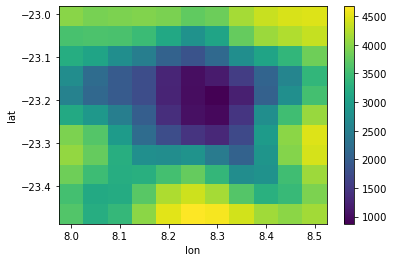

In [3]:
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT.rename({'lat','lon'})
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0)})
topo_INALT = topo_INALT.assign_coords({"lat": INALT_mask.gphit.isel(t=0,x=0)})
topo_INALT = topo_INALT.swap_dims({'x': 'lon'})
topo_INALT = topo_INALT.swap_dims({'y': 'lat'})

topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).plot();

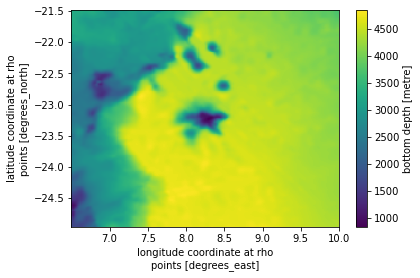

In [18]:
SIGMA.h.plot();

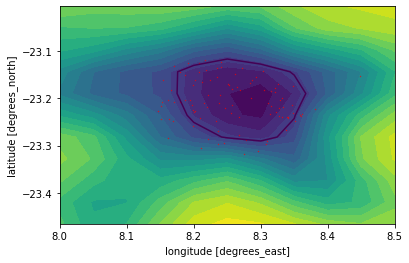

In [4]:
plt.contourf(topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)),levels=20)
plt.contour(topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)),levels=[1500])
particle_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.1,color='red')

In [6]:
retention=[]
for i in np.arange(len(particle_ds.traj)):
    for j in np.arange(len(particle_ds.obs)):
        a= topo_INALT.sel(lat=particle_ds.isel(traj=i,obs=j).lat,
               lon=particle_ds.isel(traj=i,obs=j).lon,
               method="nearest")
        retention.append([i,j,1500-a])

In [7]:
df = pd.DataFrame(np.asarray(retention), columns = ['traj','obs','depth'])
df

,traj,obs,depth
0,0.0,0.0,38.462852
1,0.0,1.0,-215.600119
2,0.0,2.0,-215.600119
3,0.0,3.0,-215.600119
4,0.0,4.0,-215.600119
...,...,...,...
4595,99.0,41.0,-3107.973037
4596,99.0,42.0,-2914.965430
4597,99.0,43.0,1500.000000
4598,99.0,44.0,1500.000000


In [9]:
atmount=[]
for i in np.arange(len(particle_ds.traj)):
    atmount.append(len(df.where(df.traj==i).dropna().where(df.depth>0).dropna()))

In [10]:
atmount=pd.DataFrame(np.asarray(atmount), columns = ['times'])
atmount

,times
0,1
1,22
2,8
3,3
4,27
...,...
95,16
96,6
97,13
98,4


In [11]:
retention_percentage=[]
for i in np.arange(len(particle_ds.obs)):
    a=len(atmount.where(atmount>i).dropna())/100
    retention_percentage.append(a)

In [23]:
#same for ROMS
retention_ROMS=[]
for i in np.arange(len(ROMS_ds.traj)):
    for j in np.arange(len(ROMS_ds.obs)):
        a= SIGMA.h.sel(lat_rho=ROMS_ds.isel(traj=i,obs=j).lat,
               lon_rho=ROMS_ds.isel(traj=i,obs=j).lon,
               method="nearest")
        retention_ROMS.append([i,j,1500-a])

ROMS_df = pd.DataFrame(np.asarray(retention_ROMS), columns = ['traj','obs','depth'])

atmount_ROMS=[]
for i in np.arange(len(ROMS_ds.traj)):
    atmount_ROMS.append(len(ROMS_df.where(ROMS_df.traj==i).dropna().where(ROMS_df.depth>0).dropna()))
    
atmount_ROMS=pd.DataFrame(np.asarray(atmount_ROMS), columns = ['times'])

retention_percentage_ROMS=[]
for i in np.arange(len(ROMS_ds.obs)):
    a=len(atmount_ROMS.where(atmount_ROMS>i).dropna())/100
    retention_percentage_ROMS.append(a)

In [27]:
#same for ROMS child
retention_ROMSchild=[]
for i in np.arange(len(ROMSchild_ds.traj)):
    for j in np.arange(len(ROMSchild_ds.obs)):
        a= SIGMA_child.h.sel(lat_rho=ROMSchild_ds.isel(traj=i,obs=j).lat,
               lon_rho=ROMSchild_ds.isel(traj=i,obs=j).lon,
               method="nearest")
        retention_ROMSchild.append([i,j,1500-a])

ROMSchild_df = pd.DataFrame(np.asarray(retention_ROMSchild), columns = ['traj','obs','depth'])

atmount_ROMSchild=[]
for i in np.arange(len(ROMSchild_ds.traj)):
    atmount_ROMSchild.append(len(ROMSchild_df.where(ROMSchild_df.traj==i).dropna().where(ROMSchild_df.depth>0).dropna()))
    
atmount_ROMSchild=pd.DataFrame(np.asarray(atmount_ROMSchild), columns = ['times'])

retention_percentage_ROMSchild=[]
for i in np.arange(len(ROMSchild_ds.obs)):
    a=len(atmount_ROMSchild.where(atmount_ROMSchild>i).dropna())/100
    retention_percentage_ROMSchild.append(a)

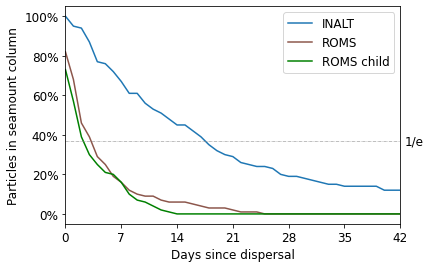

In [72]:
plt.plot(retention_percentage,label='INALT')
plt.plot(retention_percentage_ROMS, color = 'tab:brown',label='ROMS')
plt.plot(retention_percentage_ROMSchild, color = 'green',label='ROMS child')
plt.legend(fontsize=12)
plt.hlines(1/np.e,0,45,color='gray',linestyle='-.',linewidth=0.5)
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12);

In [ ]:
#same for ROMS
retention_ROMS=[]
for i in np.arange(len(ROMS_ds.traj)):
    for j in np.arange(len(ROMS_ds.obs)):
        a= SIGMA.h.sel(lat_rho=ROMS_ds.isel(traj=i,obs=j).lat,
               lon_rho=ROMS_ds.isel(traj=i,obs=j).lon,
               method="nearest")
        retention_ROMS.append([i,j,1500-a])

ROMS_df = pd.DataFrame(np.asarray(retention_ROMS), columns = ['traj','obs','depth'])

atmount_ROMS=[]
for i in np.arange(len(ROMS_ds.traj)):
    atmount_ROMS.append(len(ROMS_df.where(ROMS_df.traj==i).dropna().where(ROMS_df.depth>0).dropna()))
    
atmount_ROMS=pd.DataFrame(np.asarray(atmount_ROMS), columns = ['times'])

retention_percentage_ROMS=[]
for i in np.arange(len(ROMS_ds.obs)):
    a=len(atmount_ROMS.where(atmount_ROMS>i).dropna())/100
    retention_percentage_ROMS.append(a)